In [1]:
!pip install tensorflow==2.6.0
!pip install librosa
!pip install matplotlib
!pip install tqdm
!pip install sounddevice
!pip install tensorflow-gpu==2.6.0

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23143 sha256=514a087793d45acff41fe8f3f9e2123c43e35a29181467a4d925955d090d8597
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\49\5a\e4\df590783499a992a88de6c0898991d1167453a3196d0d1eeb7
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320719 sha256=219bfe24dfe0a7fee952ecd8da17c4f4ad151057d59b8279ec8e7d362fe20b1a
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\6f\d1\5d\f13da53b1dcbc2624ff548456c9ffb526c914f53c12c318bb4
Successfully built audioread resampy
  Using cached tensorflow_gpu-2.6.0-cp38-cp38-win_amd64.whl (423.3 MB)


In [1]:
# All samples
# labels = [
#     'left', 'cat', 'wow', 'six', 'go', 'one', 'dog', 'nine', 'sheila', 'yes',
#     'down', 'bird', 'tree', 'up', 'eight', 'bed', 'three', 'on', 'house',
#     'five', 'seven', 'zero', 'right', 'four', 'no', 'two', 'off', 'happy',
#     'stop', 'marvin'
# ]

# Subsample
labels = [
    'left', 'go', 'yes', 'down', 'up', 'on', 'right', 'no', 'off', 'stop',
]

In [2]:
import tensorflow
from tqdm import tqdm
import librosa
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from tqdm import tqdm

# 데이터 준비하기

In [3]:
train_audio_path = './train/audio/'

all_wave = []
all_label = []
for label in tqdm(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000) # image에서 normalization (1/255)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

100%|██████████| 10/10 [03:49<00:00, 22.94s/it]


In [4]:
type(all_wave), type(all_wave[0])

(list, numpy.ndarray)

In [5]:
type(all_label), type(all_label[0]), all_label[0] # 타입 확인

(list, str, 'left')

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(all_label)
classes = list(label_enconder.classes_)
y = np_utils.to_categorical(y, num_classes=len(labels))

In [7]:
type(y), y

(numpy.ndarray,
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32))

In [8]:
all_wave[0].shape # 형태 살펴보기

(8000,)

In [9]:
#conv1d 에 대한 입력은 3D배열이어야 하므로 2D배열을 3D로 변형합니다
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [10]:
all_wave.shape

(21312, 8000, 1)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)
# 데이터 나누기

In [12]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((17049, 8000, 1), (4263, 8000, 1), (17049, 10), (4263, 10))

# 모델 만들기

In [13]:
from keras.layers import Bidirectional, BatchNormalization, GRU, CuDNNGRU, TimeDistributed

In [14]:
# keras에서 모델을 생성하는 방법
# 1. sequancial: 입력이 1개(90%커버 가능)
# 2. functional: 함수형 모델
# 3. subclass

# 1,2번에서 왠만하면 마칠 것



In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint# 일찍 마치기,단계마다 저장
from keras import backend as K

inputs = Input(shape=(8000,1))
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

#First Conv1D layer
x = Conv1D(8,13, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Second Conv1D layer
x = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Third Conv1D layer
x = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Bidirectional(GRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(GRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(GRU(128, return_sequences=False), merge_mode='sum')(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

# Flatten layer
# x = Flatten()(x)

#Dense Layer 1
x = Dense(256, activation='relu')(x)
outputs = Dense(len(labels), activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0     

In [16]:
model.compile(loss = "categorical_crossentropy", optimizer= "nadam", metrics=['accuracy'])

In [17]:
# callback 만들기
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('speech2text_model_keras.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

In [18]:
hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=7, 
    callbacks=[early_stop, checkpoint], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)

Epoch 1/7
533/533 [==============================] - 59s 97ms/step - loss: 1.6972 - accuracy: 0.3709 - val_loss: 1.3970 - val_accuracy: 0.5433

Epoch 00001: val_accuracy improved from -inf to 0.54328, saving model to speech2text_model_keras.hdf5
Epoch 2/7
533/533 [==============================] - 52s 97ms/step - loss: 0.7289 - accuracy: 0.7455 - val_loss: 0.8168 - val_accuracy: 0.7267

Epoch 00002: val_accuracy improved from 0.54328 to 0.72672, saving model to speech2text_model_keras.hdf5
Epoch 3/7
533/533 [==============================] - 52s 98ms/step - loss: 0.4846 - accuracy: 0.8332 - val_loss: 0.3757 - val_accuracy: 0.8736

Epoch 00003: val_accuracy improved from 0.72672 to 0.87356, saving model to speech2text_model_keras.hdf5
Epoch 4/7
533/533 [==============================] - 52s 98ms/step - loss: 0.3854 - accuracy: 0.8697 - val_loss: 0.3961 - val_accuracy: 0.8700

Epoch 00004: val_accuracy did not improve from 0.87356
Epoch 5/7
533/533 [==============================] - 53s 

In [19]:
for key in hist.history:
    print(key)

loss
accuracy
val_loss
val_accuracy


# 모델 불러오는 방법
model = load_model('speech2text_model_keras.hdf5')

In [50]:
from keras.models import load_model
model = load_model('speech2text_model_keras.hdf5')


In [51]:
hist.history

{'loss': [0.40529394149780273, 0.3419158458709717, 0.2942819595336914],
 'accuracy': [0.8618687391281128, 0.8848026394844055, 0.9005807042121887],
 'val_loss': [0.46427854895591736, 0.3848009407520294, 0.2682346999645233],
 'val_accuracy': [0.8484635353088379, 0.8733286261558533, 0.9143795371055603]}

# 그래프 그리기

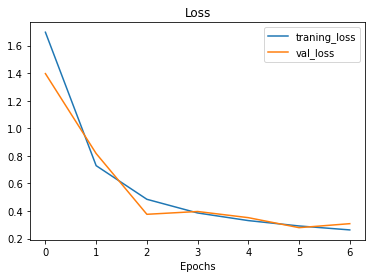

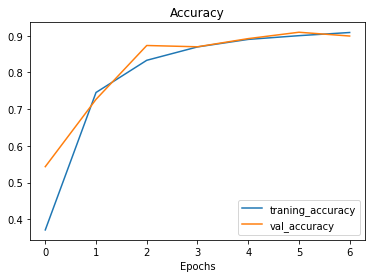

In [20]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
plot_loss_curves(hist)

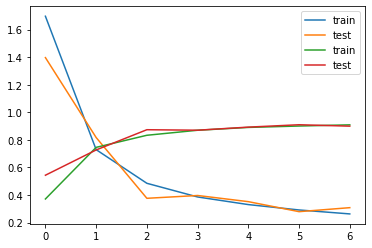

In [26]:
# 다른 방식으로 그리기
from matplotlib import pyplot
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.plot(hist.history['accuracy'], label='train')
pyplot.plot(hist.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
def s2t_predict(audio, shape_num=8000):
    prob=model.predict(audio.reshape(1,shape_num,1))
    index=np.argmax(prob[0])
    return classes[index]

In [34]:
import random
index=random.randint(0,len(x_valid)-1)
samples=x_valid[index].ravel()
print("Audio:",classes[np.argmax(y_valid[index])])
ipd.Audio(samples, rate=8000)

Audio: off


In [35]:
samples.shape

(8000,)

In [36]:
print("Text:",s2t_predict(samples))

Text: off


In [48]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'test.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [49]:
#reading the voice commands
test, test_rate = librosa.load('test.wav', sr = 16000)
test_sample = librosa.resample(test, test_rate, 8000)
print(test_sample.shape)
ipd.Audio(test_sample,rate=8000)   

(8000,)


In [50]:
s2t_predict(test_sample)

'yes'